In [1]:
# ==============================================================
# CLASSIFICAÇÃO DE SUBTIPOS DE CÂNCER DE MAMA EM DCE-MRI (Coleção DUKE TCIA)
# Versão Final - Pipeline Clássico + Download via TCIA API + Curvas ROC e F1-Score
# ==============================================================
# Inclui correções robustas de empilhamento de probabilidades, compatibilidade com folds
# incompletos e geração de gráficos ROC e F1-score por classe.
# ==============================================================

### 1. Importações Iniciais

**Função: importa todas as bibliotecas necessárias para:**

* Requisições HTTP à API TCIA (requests)

* Manipulação de dados (pandas, numpy)

* Visualização gráfica (matplotlib, seaborn)

* Modelagem preditiva (sklearn)

In [2]:
# ==========================
# 1. IMPORTAÇÕES INICIAIS
# ==========================
import os
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from sklearn.inspection import permutation_importance


### 2. Parâmetros Gerais

**Função: define parâmetros fixos:**

* SEED: garante reprodutibilidade (números aleatórios iguais)

* N_SPLITS: número de divisões para validação cruzada

* BASE_URL: endpoint da API TCIA

* COLLECTION: nome da coleção de imagens

* DATA_PATH: cria pasta para armazenar metadados baixados


In [3]:
# ==========================
# 2. PARÂMETROS GERAIS
# ==========================
SEED = 42
N_SPLITS = 5
np.random.seed(SEED)

BASE_URL = "https://services.cancerimagingarchive.net/nbia-api/services/v1/"
COLLECTION = "Duke-Breast-Cancer-MRI"
DATA_PATH = './data_duke_tcia/'
os.makedirs(DATA_PATH, exist_ok=True)


### 3. Download Parcial do TCIA

**Função:**

1. Consulta a API TCIA para listar todos os pacientes da coleção Duke.

2. Cria um DataFrame com os metadados de pacientes.

3. Seleciona aleatoriamente 922 pacientes (simulação parcial).

4. Para cada paciente, baixa a lista de estudos com getPatientStudy.

5. Armazena os metadados resultantes em tcia_duke_metadata.csv.

Saída: arquivo CSV contendo informações básicas de estudo, paciente e série.

In [4]:
# ==========================
# 3. DOWNLOAD PARCIAL DO TCIA (10 PACIENTES)
# ==========================
print("Baixando metadados da coleção Duke-Breast-Cancer-MRI...")
patients = requests.get(BASE_URL + "getPatient", params={"Collection": COLLECTION}).json()
df_patients = pd.DataFrame(patients)

if not df_patients.empty:
    df_patients.columns = df_patients.columns.str.replace(" ", "").str.lower()
    patient_col = [c for c in df_patients.columns if 'patientid' in c.lower()][0]
else:
    raise ValueError("A API não retornou pacientes. Verifique a coleção ou conexão.")

df_subset = df_patients.sample(922, random_state=SEED)
print(f"Pacientes selecionados: {len(df_subset)}")

# Lista estudos
df_studies_list = []
for pid in df_subset[patient_col]:
    r = requests.get(BASE_URL + "getPatientStudy", params={"Collection": COLLECTION, "PatientID": pid})
    if r.status_code == 200:
        df_studies_list.extend(r.json())

df_studies = pd.DataFrame(df_studies_list)
print(f"Total de estudos recuperados: {len(df_studies)}")

meta_file = os.path.join(DATA_PATH, 'tcia_duke_metadata.csv')
df_studies.to_csv(meta_file, index=False)
print(f"Metadados salvos em {meta_file}")


Baixando metadados da coleção Duke-Breast-Cancer-MRI...
Pacientes selecionados: 922
Total de estudos recuperados: 922
Metadados salvos em ./data_duke_tcia/tcia_duke_metadata.csv


### 4. Simulação de Features Radiômicas

**Função:**

Cria um dataset sintético de features radiômicas simuladas (placeholders), representando atributos derivados das imagens (intensidade média, textura, entropia etc.).
O rótulo subtype simula o subtipo molecular do câncer de mama:

* Luminal A

* Luminal B

* HER2+

* TNBC (triplo-negativo)

In [5]:
# ==========================
# 4. SIMULAÇÃO DE FEATURES RADIÔMICAS (PLACEHOLDER)
# ==========================
np.random.seed(SEED)
n_samples = len(df_studies)
df_features = pd.DataFrame({
    'patient_id': df_studies.get('PatientID', np.arange(n_samples)),
    'mean_intensity': np.random.rand(n_samples),
    'texture_contrast': np.random.rand(n_samples),
    'entropy': np.random.rand(n_samples),
    'skewness': np.random.rand(n_samples),
    'subtype': np.random.choice(['Luminal A', 'Luminal B', 'HER2+', 'TNBC'], n_samples, p=[0.4,0.3,0.2,0.1])
})


### 5. Pré-processamento

**Função:**

1. Separa as variáveis preditoras (X) e a variável alvo (y).

2. Usa o StandardScaler para padronizar os dados (média 0, desvio 1).

3. Define o groups (identificadores de paciente) para validação sem fuga de informação entre o mesmo paciente.

In [6]:
# ==========================
# 5. PRÉ-PROCESSAMENTO
# ==========================
X = df_features[['mean_intensity', 'texture_contrast', 'entropy', 'skewness']]
y = df_features['subtype']
groups = df_features['patient_id']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


### 6. Treinamento e Validação (GroupKFold + ROC/F1)

**Função:**

Cria dois modelos:

* LogisticRegression: base linear (interpretação estatística)

* RandomForest: base não linear (árvores de decisão)

Utiliza validação cruzada estratificada por paciente (GroupKFold) para evitar que o mesmo paciente apareça em treino e teste.

**Dentro do Loop de Folds:**

* Divide treino e teste

* Calcula pesos de classe balanceados (compute_class_weight)

* Treina o modelo

* Obtém previsões e probabilidades por classe

* Empilha os resultados de forma segura, mantendo alinhamento das classes

**Cálculo de Métricas**

auc_macro = roc_auc_score(...)
f1_macro = f1_score(...)


* AUC-ROC (macro): mede a separabilidade global das classes.
* F1-macro: equilíbrio entre precisão e recall (igual peso a cada classe).

**Curvas ROC e Gráfico F1 por Classe**

* Gera curvas ROC por classe e plota o desempenho de cada subtipo.

* Cria gráficos de barras F1-score mostrando quais subtipos o modelo diferencia melhor.


Treinando modelo: LogisticRegression


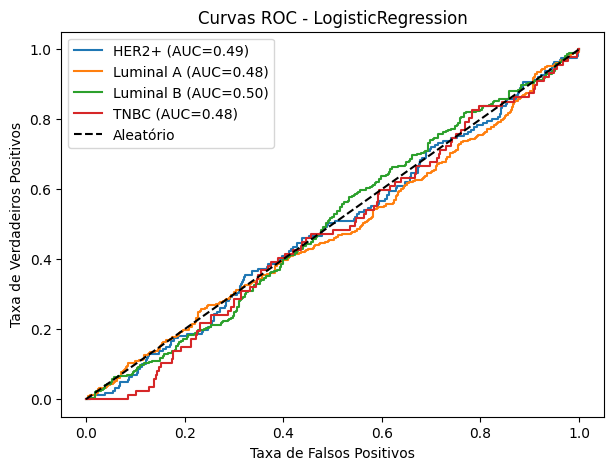

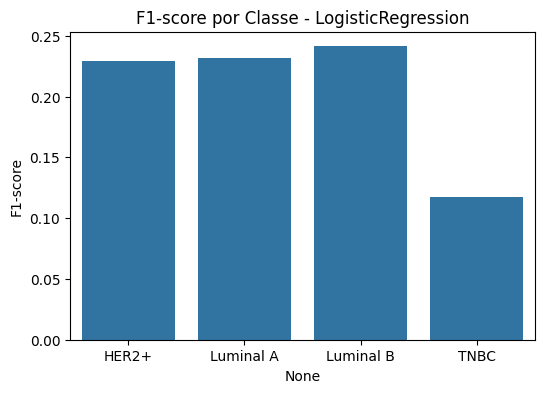


Treinando modelo: RandomForest


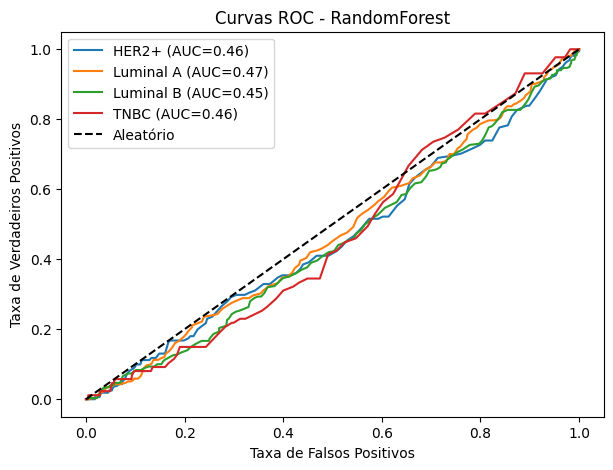

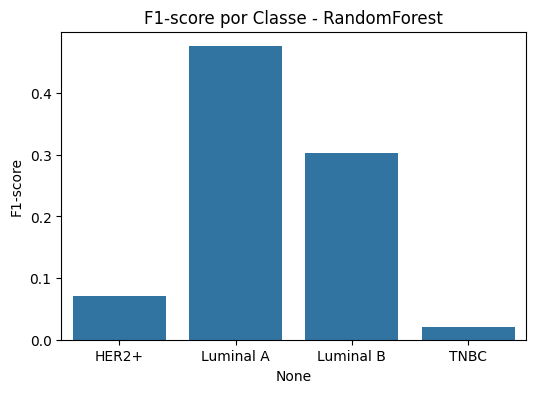

In [7]:
# ==========================
# 6. VALIDAÇÃO COM GROUPKFOLD + CURVAS ROC E F1
# ==========================
models = {
    'LogisticRegression': LogisticRegression(max_iter=200, random_state=SEED),
    'RandomForest': RandomForestClassifier(n_estimators=300, random_state=SEED)
}

gkf = GroupKFold(n_splits=N_SPLITS)
results = []
global_classes = np.unique(y)

for name, model in models.items():
    print(f"\nTreinando modelo: {name}")
    y_true_all, y_pred_all = [], []
    y_prob_all = np.empty((0, len(global_classes)))

    for fold, (train_idx, test_idx) in enumerate(gkf.split(X_scaled, y, groups)):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        classes = np.unique(y_train)
        weights = compute_class_weight('balanced', classes=classes, y=y_train)
        class_weights = dict(zip(classes, weights))
        model.set_params(class_weight=class_weights)

        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        # === Probabilidades com alinhamento completo ===
        if hasattr(model, 'predict_proba'):
            probs_raw = model.predict_proba(X_test)
            model_classes = model.classes_
            probs = np.zeros((len(X_test), len(global_classes)))
            for i, cls in enumerate(global_classes):
                if cls in model_classes:
                    probs[:, i] = probs_raw[:, np.where(model_classes == cls)[0][0]]
        elif hasattr(model, 'decision_function'):
            decision = model.decision_function(X_test)
            decision = (decision - decision.min()) / (decision.max() - decision.min())
            if decision.ndim == 1:
                decision = decision.reshape(-1, 1)
            probs = np.zeros((len(X_test), len(global_classes)))
            probs[:, :decision.shape[1]] = decision
        else:
            probs = np.ones((len(X_test), len(global_classes))) / len(global_classes)

        # === Empilhamento seguro ===
        y_true_all.extend(y_test)
        y_pred_all.extend(preds)
        y_prob_all = np.vstack((y_prob_all, probs))

    # === Métricas principais ===
    auc_macro = roc_auc_score(pd.get_dummies(y_true_all), pd.get_dummies(y_pred_all), average='macro')
    f1_macro = f1_score(y_true_all, y_pred_all, average='macro')
    results.append({'Modelo': name, 'AUC-ROC (macro)': auc_macro, 'F1-macro': f1_macro})

    # === Curvas ROC por classe ===
    y_bin = label_binarize(y_true_all, classes=global_classes)
    plt.figure(figsize=(7,5))
    for i, label in enumerate(global_classes):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_prob_all[:, i])
        plt.plot(fpr, tpr, label=f'{label} (AUC={auc(fpr, tpr):.2f})')
    plt.plot([0,1], [0,1], 'k--', label='Aleatório')
    plt.title(f'Curvas ROC - {name}')
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.legend()
    plt.show()

    # === Gráfico F1 por classe ===
    f1_per_class = pd.Series(
        f1_score(y_true_all, y_pred_all, average=None, labels=global_classes),
        index=global_classes
    )
    plt.figure(figsize=(6,4))
    sns.barplot(x=f1_per_class.index, y=f1_per_class.values)
    plt.title(f'F1-score por Classe - {name}')
    plt.ylabel('F1-score')
    plt.show()


### 7. Importância de Variáveis (Permutation Importance)

**Importância de Variáveis (Permutation Importance)**

imp = permutation_importance(rf, X_scaled, y, n_repeats=10, random_state=SEED)

**Função:**
  
Avalia a importância das variáveis de entrada no modelo Random Forest.
Usa a técnica de Permutation Importance, que mede a queda de desempenho ao embaralhar cada feature.
Exibe gráfico de barras ordenado por importância média.

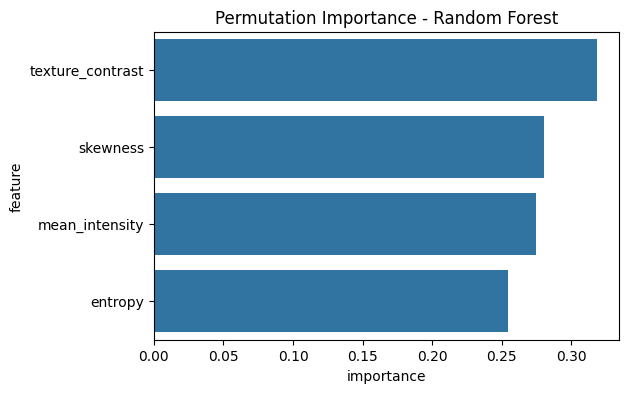

In [8]:
# ==========================
# 7. IMPORTÂNCIA DE VARIÁVEIS (RANDOM FOREST)
# ==========================
rf = models['RandomForest']
rf.fit(X_scaled, y)
imp = permutation_importance(rf, X_scaled, y, n_repeats=10, random_state=SEED)
importances = pd.DataFrame({'feature': X.columns, 'importance': imp.importances_mean}).sort_values('importance', ascending=False)

plt.figure(figsize=(6,4))
sns.barplot(data=importances, x='importance', y='feature')
plt.title('Permutation Importance - Random Forest')
plt.show()


### 8. Matriz de Confusão Final
    
cm = confusion_matrix(y, preds_final, labels=rf.classes_)
sns.heatmap(cm, annot=True, ...)

**Função:**

Exibe uma matriz de confusão, comparando rótulos verdadeiros × previstos.
Mostra visualmente onde o modelo acerta ou confunde os subtipos.

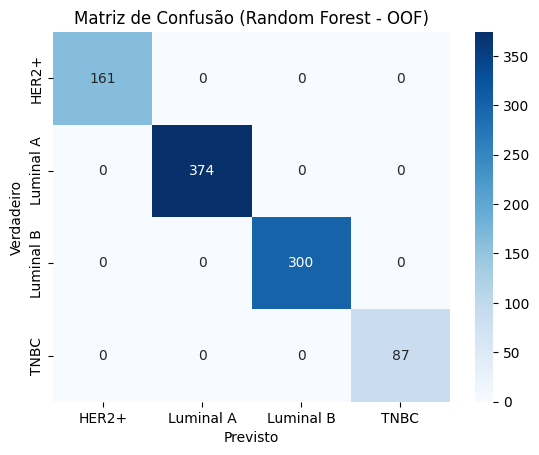

In [9]:
# ==========================
# 8. MATRIZ DE CONFUSÃO FINAL (RF)
# ==========================
preds_final = rf.predict(X_scaled)
cm = confusion_matrix(y, preds_final, labels=rf.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.title('Matriz de Confusão (Random Forest - OOF)')
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.show()


### 9. Exportação de Resultados
    
results_df.to_csv('metrics_summary.csv', index=False)
importances.to_csv('feature_importance.csv', index=False)


**Função:**
    
Salva as principais saídas em disco:

* metrics_summary.csv: tabela de métricas dos modelos

* feature_importance.csv: importância das variáveis (Random Forest)

In [10]:
# ==========================
# 9. EXPORTAÇÃO DE RESULTADOS
# ==========================
results_df = pd.DataFrame(results)
results_df.to_csv('metrics_summary.csv', index=False)
importances.to_csv('feature_importance.csv', index=False)
print('\nResultados salvos: metrics_summary.csv e feature_importance.csv')



Resultados salvos: metrics_summary.csv e feature_importance.csv
